In [1]:
!git clone https://github.com/leeprinxin/VerificationCode_FasterRCNN.git

Cloning into 'VerificationCode_FasterRCNN'...
remote: Enumerating objects: 802, done.
remote: Counting objects: 100% (802/802), done.
remote: Compressing objects: 100% (796/796), done.
remote: Total 802 (delta 2), reused 801 (delta 1), pack-reused 0
Receiving objects: 100% (802/802), 1.30 MiB | 31.03 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
import cv2
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns

# BBox Convert To CSV

In [3]:
TRAIN_FOLDER_PATH = "/content/VerificationCode_FasterRCNN/驗證碼Dataset/Dataset/train"

# Read images in folder
def ConvertBBoxToCSV(folder, is_train=True):
    images = []
    bboxfolder = os.path.join(folder,'bbox')
    imgfolder = os.path.join(folder,'img')
    df_dict = {
        'image_id':[],
        'width':[],
        'height':[],
        'bbox':[],
        'label':[]
    }
    for filename in os.listdir(bboxfolder):
        image = cv2.imread(os.path.join(imgfolder,filename[:-4]+'.jpg'))
        bboxfile = os.path.join(bboxfolder,filename)
        h,w = image.shape[:2]
        bboxes = get_bbox(bboxfile,h,w)
        for label,x_center,y_center,bw,bh in bboxes:
            df_dict['image_id'] += [filename[:-4]]
            df_dict['width'] += [w]
            df_dict['height'] += [h]
            df_dict['bbox'] += [[x_center-(bw/2),y_center-(bh/2),bw,bh]]
            df_dict['label'] += [label]
    return df_dict

def get_bbox(path, height=0, width=0):
    bboxes = []
    with open(path,'r') as f:
        for line in f:
            label,x_center_scale,y_center_scale,w_scale,h_scale=line.split(' ')
            bboxes.append([label,float(x_center_scale)*width,
                       float(y_center_scale)*height,
                       float(w_scale)*width,
                       float(h_scale)*height])

        return bboxes


In [4]:
df_dict = ConvertBBoxToCSV(TRAIN_FOLDER_PATH, is_train=True)
pd.DataFrame(df_dict).to_csv(TRAIN_FOLDER_PATH+'/train.csv')

# 讀取資料

In [5]:
DIR_INPUT = '/content/VerificationCode_FasterRCNN/驗證碼Dataset/Dataset'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [6]:
train_df = pd.read_csv(f'{DIR_TRAIN}/train.csv')
train_df.head()

,Unnamed: 0,image_id,width,height,bbox,label
0,0,3ET42M,200,60,"[4.999999999999998, 13.0, 19.0, 21.0]",3
1,1,3ET42M,200,60,"[28.0, 17.999999999999996, 25.0, 26.0]",14
2,2,3ET42M,200,60,"[58.0, 28.0, 23.0, 22.0]",29
3,3,3ET42M,200,60,"[96.0, 20.0, 19.0, 20.0]",4
4,4,3ET42M,200,60,"[120.0, 11.0, 18.0, 22.0]",2


In [7]:
train_df[['x','y','w','h']] = 0
train_df[['x','y','w','h']] = np.stack(train_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=','))).astype(np.float)
train_df.drop(columns=['bbox'], inplace=True)
train_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


,Unnamed: 0,image_id,width,height,label,x,y,w,h
0,0,3ET42M,200,60,3,5.0,13.0,19.0,21.0
1,1,3ET42M,200,60,14,28.0,18.0,25.0,26.0
2,2,3ET42M,200,60,29,58.0,28.0,23.0,22.0
3,3,3ET42M,200,60,4,96.0,20.0,19.0,20.0
4,4,3ET42M,200,60,2,120.0,11.0,18.0,22.0


In [8]:
len((train_df['label'].unique()))

36

In [9]:
train_df.shape

(1999, 9)

是否缺少標記

In [10]:
train_df['image_id'].nunique()-len(os.listdir(DIR_TRAIN+'/img'))

0

In [11]:
train_df['width'].unique(), train_df['height'].unique()

(array([200]), array([60]))

標記數量分布

number of boxes, range [5, 6]


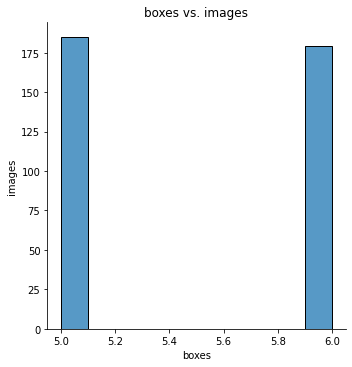

In [12]:
counts = train_df['image_id'].value_counts()
print(f'number of boxes, range [{min(counts)}, {max(counts)}]')
sns.displot(counts, kde=False)
plt.xlabel('boxes')
plt.ylabel('images')
plt.title('boxes vs. images')
plt.show()

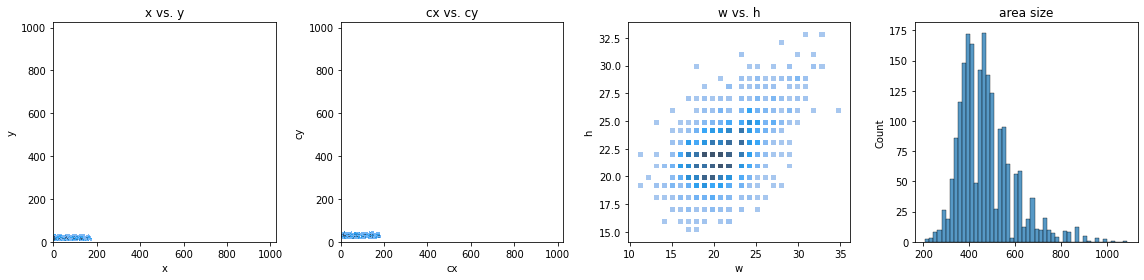

In [13]:
train_df['cx'] = train_df['x'] + train_df['w'] / 2
train_df['cy'] = train_df['y'] + train_df['h'] / 2

ax = plt.subplots(1, 4, figsize=(16, 4), tight_layout=True)[1].ravel()
ax[0].set_title('x vs. y')
ax[0].set_xlim(0, 1024)
ax[0].set_ylim(0, 1024)
ax[1].set_title('cx vs. cy')
ax[1].set_xlim(0, 1024)
ax[1].set_ylim(0, 1024)
ax[2].set_title('w vs. h')
ax[3].set_title('area size')
sns.histplot(data=train_df, x='x', y='y', ax=ax[0], bins=50, pmax=0.9)
sns.histplot(data=train_df, x='cx', y='cy', ax=ax[1], bins=50, pmax=0.9)
sns.histplot(data=train_df, x='w', y='h', ax=ax[2], bins=50, pmax=0.9)
sns.histplot(train_df['w'] * train_df['h'], ax=ax[3], bins=50, kde=False)
plt.show()

In [14]:
image_ids = train_df['image_id'].unique()

split_len = round(len(image_ids)*0.8)

train_ids = image_ids[:split_len]
valid_ids = image_ids[split_len:]

train = train_df[train_df['image_id'].isin(train_ids)]
valid = train_df[train_df['image_id'].isin(valid_ids)]

train.shape, valid.shape

((1595, 11), (404, 11))

In [15]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  
  _, axes = plt.subplots(num_rows, num_cols,figsize = figsize)
  _.tight_layout()
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles and len(titles) > i:
      ax.set_title(titles[i])
  return axes

def show_bboxes(axes, bboxes, labels=None, colors=None):
  def _make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj

  labels = _make_list(labels)
  colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = plt.Rectangle(
      xy=(bbox[0], bbox[1]),
      width=bbox[2] - bbox[0],
      height=bbox[3] - bbox[1],
      fill=False,
      edgecolor=color,
      linewidth=2)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

    
    


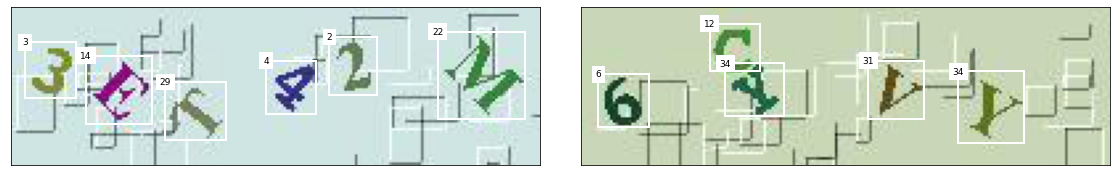

In [16]:
num_rows, num_cols = 1, 2
ids = train_df['image_id'].unique()[:num_rows*num_cols]
imgs = [plt.imread(f'{DIR_TRAIN}/img/{n}.jpg') for n in ids]

axes = show_images(imgs, num_rows, num_cols, scale=8)
for ax, id in zip(axes, ids):
  datas = train_df[train_df['image_id'] == id]
  bboxes = [(d['x'], d['y'], d['x']+d['w'], d['y']+d['h']) for _, d in datas.iterrows()]
  
  show_bboxes(ax, bboxes, labels=list(datas['label']), colors=['w'])
  
plt.show()

# 建立DataSeet

In [52]:
import cv2 as cv
import numpy as np

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.utils.data import Dataset


class Wheat(Dataset):

  def __init__(self, dataframe, image_dir, transforms=None):
    super().__init__()
    self.image_ids = dataframe['image_id'].unique()
    self.df = dataframe
    self.image_dir = image_dir
    self.transforms = transforms

  def __getitem__(self, idx: int):
    image_id = self.image_ids[idx]
    records = self.df[self.df['image_id'] == image_id]

    image = cv.imread(f'{self.image_dir}/{image_id}.jpg', cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    boxes = records[['x', 'y', 'w', 'h']].values

    area = boxes[:, 2] * boxes[:, 3]
    area = torch.as_tensor(area, dtype=torch.float32)

    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

    # there is only one class
    
    labels = torch.tensor(list(records['label']), dtype=torch.int64)
    # suppose all instances are not crowd
    iscrowd = torch.zeros((records.shape[0],), dtype=torch.uint8)

    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = torch.tensor([idx])
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transforms:
      sample = {
        'image': image,
        'bboxes': target['boxes'],
        'labels': labels,
      }
      sample = self.transforms(**sample)
      image = sample['image']
      target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

    return image, target, image_id

  def __len__(self) -> int:
    return len(self.image_ids)

  # albumentations
  #  https://github.com/albumentations-team/albumentations

  @staticmethod
  def get_train_transform():
    return A.Compose([
      A.Flip(0.5),
      ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

  @staticmethod
  def get_valid_transform():
    return A.Compose([
      ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [53]:
train_dataset = Wheat(train, DIR_TRAIN+'/img', Wheat.get_train_transform())
valid_dataset = Wheat(valid, DIR_TRAIN+'/img', Wheat.get_valid_transform())

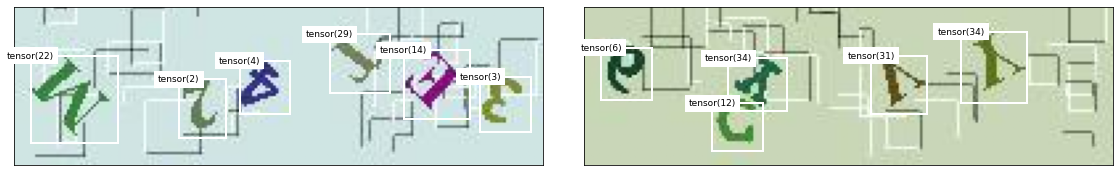

In [54]:
datas = [train_dataset[i] for i in range(2)]
imgs = [d[0].permute(1, 2, 0).numpy() for d in datas]
axes = show_images(imgs, 1, 2, scale=8)
for ax, (image, target, image_id) in zip(axes, datas):
  show_bboxes(ax, target['boxes'], labels=list(target['labels']), colors=['w'])
plt.show()

# 建立模型

In [68]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [69]:
num_classes = len((train_df['label'].unique()))+1
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [70]:
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=37, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=148, bias=True)
)


In [71]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  return tuple(zip(*batch))

train_data_loader = DataLoader(
  train_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=4,
  collate_fn=collate_fn
)

valid_data_loader = DataLoader(
  valid_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=4,
  collate_fn=collate_fn
)

In [72]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# create an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# create a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# train it for 10 epochs
num_epochs = 10

In [73]:
import time
from tqdm import tqdm
#from tqdm.notebook import tqdm as tqdm

itr = 1

total_train_loss = []
total_valid_loss = []

losses_value = 0

for epoch in range(num_epochs):

  start_time = time.time()

  # train ------------------------------

  model.train()
  train_loss = []

  pbar = tqdm(train_data_loader, desc='let\'s train')
  for images, targets, image_ids in pbar:

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
   
    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    losses_value = losses.item()
    train_loss.append(losses_value)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}")
    itr += 1

  epoch_train_loss = np.mean(train_loss)
  total_train_loss.append(epoch_train_loss)

  # update the learning rate
  if lr_scheduler is not None:
    lr_scheduler.step()

  # valid ------------------------------

  with torch.no_grad():
    valid_loss = []

    for images, targets, image_ids in valid_data_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      loss_dict = model(images, targets)

      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()
      valid_loss.append(loss_value)

  epoch_valid_loss = np.mean(valid_loss)
  total_valid_loss.append(epoch_valid_loss)

  # print ------------------------------

  print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")

Epoch: 1, Batch: 73, Loss: 1.6034218532422397: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]


Epoch Completed: 1/10, Time: 58.85037803649902, Train Loss: 1.7860530323589858, Valid Loss: 1.5992552620461835


Epoch: 2, Batch: 146, Loss: 1.3967664687823806: 100%|██████████| 73/73 [00:51<00:00,  1.42it/s]


Epoch Completed: 2/10, Time: 57.933868408203125, Train Loss: 1.3693320220960263, Valid Loss: 1.3249313112869097


Epoch: 3, Batch: 219, Loss: 1.036676228226814: 100%|██████████| 73/73 [00:52<00:00,  1.40it/s]


Epoch Completed: 3/10, Time: 58.24476480484009, Train Loss: 1.1324986346588295, Valid Loss: 1.1889305883913475


Epoch: 4, Batch: 292, Loss: 0.9798430655746814: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]


Epoch Completed: 4/10, Time: 57.89438223838806, Train Loss: 0.9981461565215525, Valid Loss: 1.0626569347612076


Epoch: 5, Batch: 365, Loss: 0.8236902125736812: 100%|██████████| 73/73 [00:51<00:00,  1.40it/s]


Epoch Completed: 5/10, Time: 58.66440224647522, Train Loss: 0.8559922873206034, Valid Loss: 0.9083863358134897


Epoch: 6, Batch: 438, Loss: 0.7376604459361518: 100%|██████████| 73/73 [00:52<00:00,  1.40it/s]


Epoch Completed: 6/10, Time: 58.53495693206787, Train Loss: 0.7609955277565549, Valid Loss: 0.8868485640149063


Epoch: 7, Batch: 511, Loss: 0.5976947843852037: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]


Epoch Completed: 7/10, Time: 57.87596392631531, Train Loss: 0.6800949962092291, Valid Loss: 0.8207551265560439


Epoch: 8, Batch: 584, Loss: 0.5906566191864865: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]


Epoch Completed: 8/10, Time: 57.97254800796509, Train Loss: 0.6187806115757603, Valid Loss: 0.8281485221266415


Epoch: 9, Batch: 657, Loss: 0.5946857093352051: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]


Epoch Completed: 9/10, Time: 57.898194313049316, Train Loss: 0.5553043127265068, Valid Loss: 0.7176256551496231


Epoch: 10, Batch: 730, Loss: 0.474741811456267: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]


Epoch Completed: 10/10, Time: 57.864696741104126, Train Loss: 0.5105898604244252, Valid Loss: 0.7025813494875494


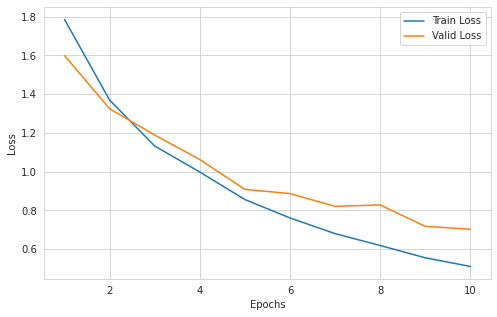

In [74]:
plt.figure(figsize=(8, 5))
sns.set_style(style="whitegrid")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [75]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

# 預測

In [76]:
class WheatTest(Dataset):

  def __init__(self, image_ids, image_dir, transforms=None):
    super().__init__()
    self.image_ids = image_ids
    self.image_dir = image_dir
    self.transforms = transforms

  def __getitem__(self, idx: int):
    image_id = self.image_ids[idx]

    image = cv.imread(f'{self.image_dir}/{image_id}.jpg', cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    if self.transforms:
      sample = {
        'image': image,
      }
      sample = self.transforms(**sample)
      image = sample['image']

    return image, image_id

  def __len__(self) -> int:
    return len(self.image_ids)

  @staticmethod
  def get_test_transform():
    return A.Compose([
      ToTensorV2(p=1.0)
    ])

In [81]:
def get_image_ids(p):
  import glob
  image_ids = []
  for p in glob.glob(f'{p}/*.jpg'):
    n, _ = os.path.splitext(os.path.basename(p))
    image_ids.append(n)
  return image_ids


test_dataset = WheatTest(get_image_ids(DIR_TEST+'/img'), DIR_TEST+'/img', WheatTest.get_test_transform())

In [84]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  return tuple(zip(*batch))

test_data_loader = DataLoader(
  test_dataset,
  batch_size=2,
  shuffle=False,
  num_workers=4,
  drop_last=False,
  collate_fn=collate_fn
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [97]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# create a Faster R-CNN model without pre-trained
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

num_classes = len((train_df['label'].unique()))+1

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
WEIGHTS_FILE = '/content/fasterrcnn_resnet50_fpn.pth'
# load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))
model.eval()

# move model to the right device
_ = model.to(device)

In [148]:
score_threshold = 0.6
image_outputs = []

for images, image_ids in test_data_loader:
  images = list(image.to(device) for image in images)
  outputs = model(images)

  for image_id, output in zip(image_ids, outputs):
      
    boxes = output['boxes'].data.cpu().numpy()
    scores = output['scores'].data.cpu().numpy()
    labels = output['labels'].data.cpu().numpy()
    mask = scores >= score_threshold

    boxes = boxes[mask].astype(np.int32)
    scores = scores[mask]
    labels = labels[mask]
    
    image_outputs.append((image_id, boxes, scores, labels))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


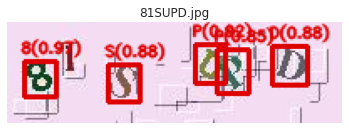

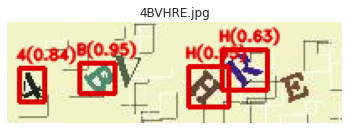

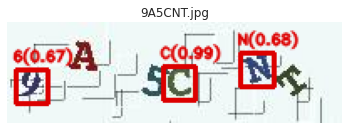

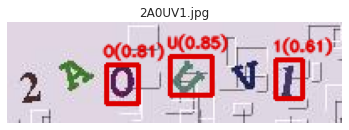

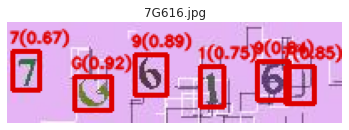

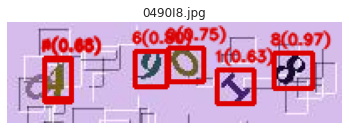

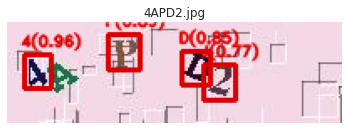

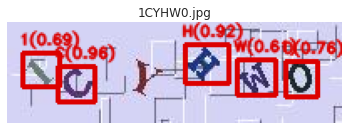

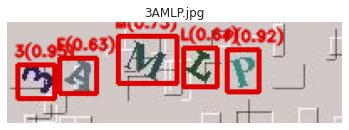

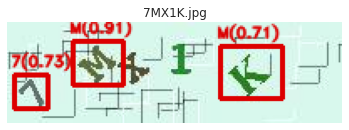

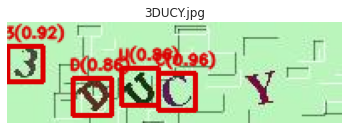

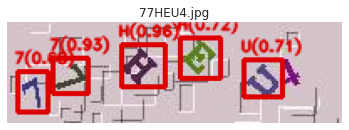

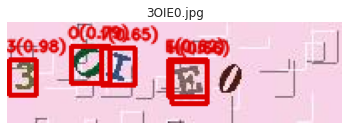

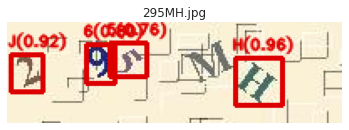

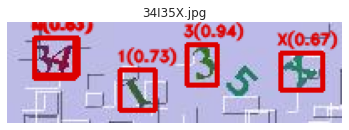

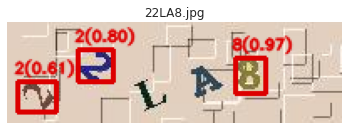

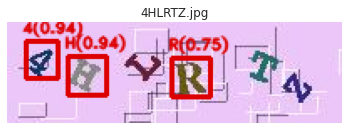

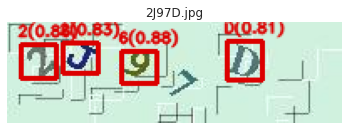

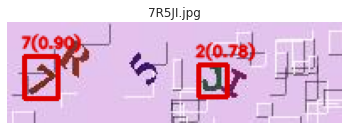

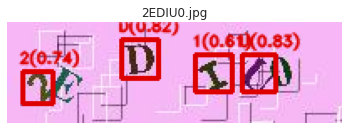

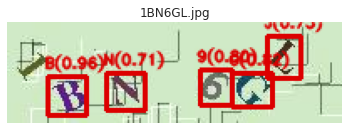

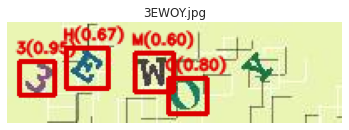

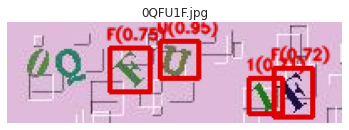

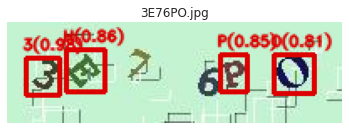

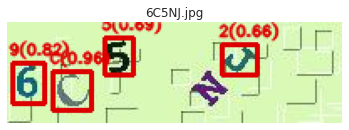

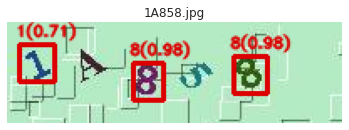

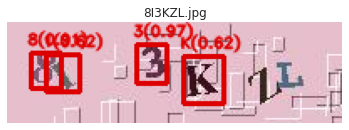

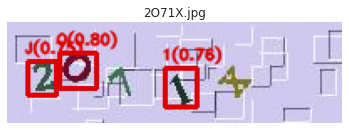

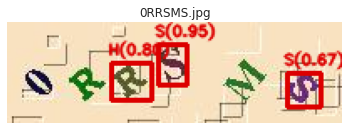

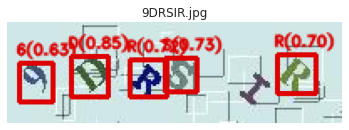

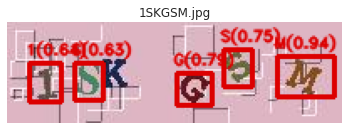

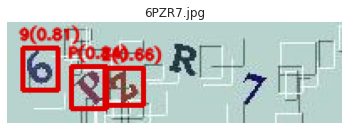

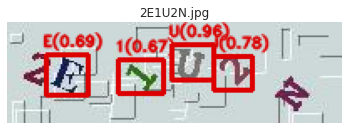

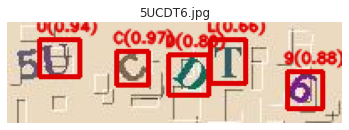

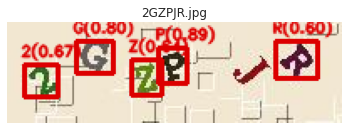

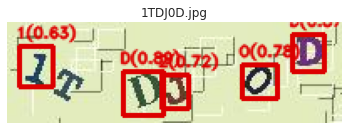

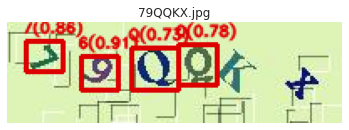

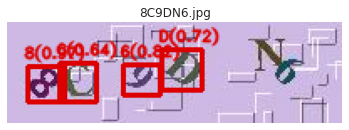

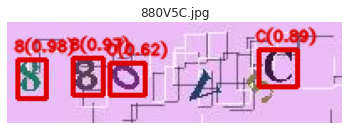

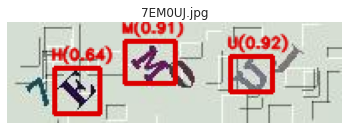

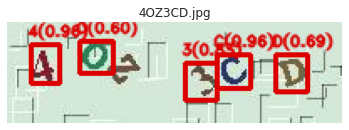

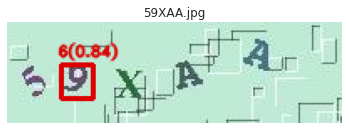

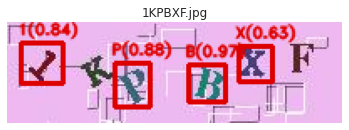

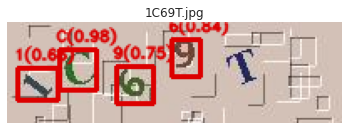

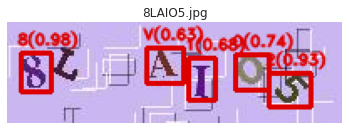

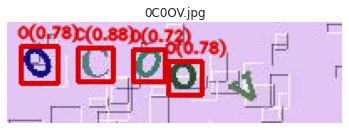

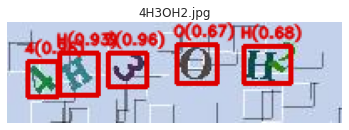

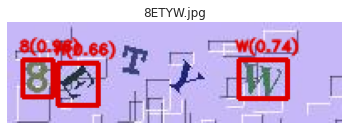

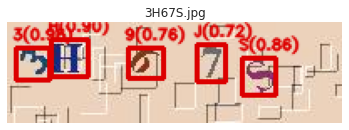

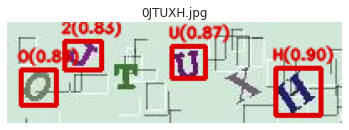

In [173]:
import string
try:
    os.mkdir('predict')
except:
    pass
classe_names = [0,1,2,3,4,5,6,7,8,9]+list(string.ascii_uppercase)

fig_n = len(image_outputs)

for i in range(1, fig_n):
  image, image_id = test_dataset[i]
  _, boxes, scores, labels = image_outputs[i]

  sample = (image.permute(1, 2, 0).cpu().numpy()*255).astype(np.uint8)

  for i in range(len(boxes)):
    cv.rectangle(sample, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), (220, 0, 0), 2)
  
    cv.putText(sample, f"{classe_names[labels[i]]}({scores[i]:.2f})", (boxes[i][0]-2, boxes[i][1]-5), cv2.FONT_HERSHEY_DUPLEX,0.3, (220, 0, 0), 1, cv2.LINE_AA)
  
  plt.figure()
  plt.title(image_id+'.jpg')
  plt.imshow(sample)
  plt.axis('off')
  plt.savefig('predict/'+image_id+'.jpg')
